In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.layers import MaxPooling2D as KMaxPooling2D
from keras.datasets import cifar10, mnist
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
 
from deconvnet.deconv2D import Deconv2D
from deconvnet.pool_unpool import MaxPooling2D, UndoMaxPooling2D
from deconvnet.forward_backward import truncated_model, backward_network

Using TensorFlow backend.


In [3]:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
y_train = np_utils.to_categorical(y_train0)
y_test = np_utils.to_categorical(y_test0)

In [13]:
# For CIFAR-10
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=5, input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(filters=16, kernel_size=5, input_shape=(32, 32, 3), activation="relu"))
model.add(KMaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(KMaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation="tanh"))
model.add(Dense(10, activation="softmax"))

In [21]:
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [23]:
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 16s 319us/step - loss: 1.3267 - acc: 0.5283 - val_loss: 1.3886 - val_acc: 0.5025
Epoch 2/20
50000/50000 [==============================] - 16s 325us/step - loss: 1.3074 - acc: 0.5347 - val_loss: 1.3977 - val_acc: 0.5005
Epoch 3/20
50000/50000 [==============================] - 15s 306us/step - loss: 1.2948 - acc: 0.5386 - val_loss: 1.4387 - val_acc: 0.4903
Epoch 4/20
50000/50000 [==============================] - 13s 252us/step - loss: 1.2774 - acc: 0.5469 - val_loss: 1.3685 - val_acc: 0.5069
Epoch 5/20
50000/50000 [==============================] - 16s 328us/step - loss: 1.2601 - acc: 0.5524 - val_loss: 1.4730 - val_acc: 0.4742
Epoch 6/20
50000/50000 [==============================] - 13s 268us/step - loss: 1.2454 - acc: 0.5571 - val_loss: 1.4025 - val_acc: 0.5024
Epoch 7/20
50000/50000 [==============================] - 15s 292us/step - loss: 1.2345 - acc: 0.5637 - val_loss: 1.

In [19]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 114us/step


[1.115808279323578, 0.6222]

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       51328     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                204864    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total para

In [80]:
trunc_net = truncated_model(model, "max_pooling2d_4")
backward_net = backward_network(trunc_net)

In [53]:
x_train_trunc_predict = trunc_net.predict(x_train)
x_train_trunc_predict[0].shape

In [46]:
max_prediction = x_train_trunc_predict[0].max(axis=(1,2))
max_prediction = max_prediction.max(axis=1)
max_prediction.argsort()[-5:]

In [ ]:
idx = [13174, 25616, 43490, 16369, 48141]

In [81]:
fwd_out = trunc_net.predict(x_train[[43490]])
_, _, _, filters = fwd_out[0].shape
f0 = fwd_out[0]

In [82]:
fwd_out[0][0,:,:,].max(axis=(0,1)).argsort()[:-5:-1]

array([121, 100,  94,  54])

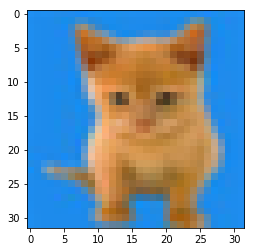

In [78]:
plt.imshow(x_train[43490])

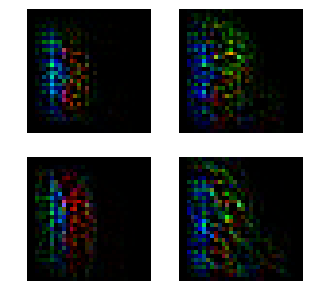

In [84]:
# Interesting filters : i = 70 for ears, 214 for mustache, 286 for face, 349 for ears again
plt.figure(figsize=(5,5))
for j, i in enumerate([121, 100,  94,  54]):
    f = f0.copy()
    fwd_out[0] = f
    fwd_out[0][:, :, :, np.arange(filters) != i] = 0
    backward_output = backward_net.predict(fwd_out)
    img = backward_output[0]/backward_output[0].max()
    plt.subplot(2,2,j+1)
    plt.axis("off")
    plt.imshow(img[:,:], cmap="gray")
plt.show()